In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import os
import time
import wandb
import torch
import random
import torchvision

import numpy as np
import pandas as pd
import torchmetrics as tm 
# import plotly.express as px
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path, PurePath
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
# from warmup_scheduler import GradualWarmupScheduler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

import albumentations as A
# from albumentations.pytorch import ToTensorV2

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, LearningRateMonitor
from torchmetrics.wrappers import ClasswiseWrapper
from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelAccuracy, MultilabelPrecision, MultilabelRecall, MultilabelF1Score

import timm

In [3]:
print('timm version', timm.__version__)
print('torch version', torch.__version__)

timm version 1.0.8
torch version 2.3.1


In [4]:
wandb.login(key=os.getenv('wandb_api_key'))

wandb: Currently logged in as: rosu-lucian. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Asus\.netrc


True

In [5]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [6]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Config

In [7]:
# TODO: maybe use condition and level for classes
classes = ['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS'] + ['H'] # add healthy class

# classes = ['SCS', 'RNFN', 'LNFN'] + ['H'] # add healthy class

# classes = ['LSS', 'RSS'] + ['H'] # add healthy class

# classes = ['SCSL1L2', 'SCSL2L3', 'SCSL3L4', 'SCSL4L5', 'SCSL5S1', 'RNFNL4L5',
#        'RNFNL5S1', 'RNFNL3L4', 'RNFNL1L2', 'RNFNL2L3', 'LNFNL1L2',
#        'LNFNL4L5', 'LNFNL5S1', 'LNFNL2L3', 'LNFNL3L4', 'LSSL1L2',
#        'RSSL1L2', 'LSSL2L3', 'RSSL2L3', 'LSSL3L4', 'RSSL3L4', 'LSSL4L5',
#        'RSSL4L5', 'LSSL5S1', 'RSSL5S1'] + ['H']

num_classes = len(classes)
class2id = {b: i for i, b in enumerate(classes)}

In [8]:
train_dir = Path('E:\data\RSNA2024')

class CFG:

    project = 'rsna-2'
    comment = 'all-labels'

    ckpt_path = Path(r"E:\data\RSNA2024\results\ckpt\eca_nfnet_l0 5e-05 10 eps 128neck\ep_04_loss_0.17137.ckpt")
    embeds_path = Path(r"E:\data\RSNA2024\embeddings")
    stacked_path = Path(r"E:\data\RSNA2024\embeddings_stacked")

    ### model
    model_name = 'eca_nfnet_l0' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 

    image_size = 256
    bottleneck_dim = 128
    
    ROOT_FOLDER = train_dir
    DEST_FOLDER = train_dir
    IMAGES_DIR = ROOT_FOLDER / 'train_images'
    PNG_DIR = ROOT_FOLDER / f'pngs_{image_size}'
    FILES_CSV = ROOT_FOLDER / 'train_files.csv'
    TRAIN_CSV = ROOT_FOLDER / 'train.csv'
    TRAIN_DESC_CSV = ROOT_FOLDER / 'train_series_descriptions.csv'
    COORDS_CSV = ROOT_FOLDER / 'train_label_coordinates.csv'

    RESULTS_DIR = train_dir / 'results'
    CKPT_DIR = RESULTS_DIR / 'ckpt'

    classes = classes

    split_fraction = 0.95

    MIXUP = False

    ### training
    BATCH_SIZE = 128
    
    ### Optimizer
    N_EPOCHS = 10
    USE_SCHD = False
    WARM_EPOCHS = 3
    COS_EPOCHS = N_EPOCHS - WARM_EPOCHS

    # LEARNING_RATE = 5*1e-5 # best
    LEARNING_RATE = 5e-5
    
    weight_decay = 1e-6 # for adamw

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    ### split train and validation sets
    num_workers = 16

    random_seed = 42

CFG.N_LABELS = len(CFG.classes)

seed_torch(seed = CFG.random_seed)

In [9]:
labels = CFG.classes
pred_labels = [f'pred_{l}' for l in labels]

labels, pred_labels

(['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS', 'H'],
 ['pred_SCS', 'pred_RNFN', 'pred_LNFN', 'pred_LSS', 'pred_RSS', 'pred_H'])

In [10]:
CFG.N_LABELS 

6

### Load data

In [11]:
train_df = pd.read_csv(CFG.TRAIN_CSV)
train_desc_df = pd.read_csv(CFG.TRAIN_DESC_CSV)
coords_df = pd.read_csv(CFG.COORDS_CSV)
files_df = pd.read_csv(CFG.FILES_CSV)

train_df.shape, train_desc_df.shape, coords_df.shape, files_df.shape

((1975, 26), (6294, 3), (48692, 18), (147218, 20))

In [12]:
train_df.sample(5)

,study_id,SCSL1L2,SCSL2L3,SCSL3L4,SCSL4L5,SCSL5S1,LNFNL1L2,LNFNL2L3,LNFNL3L4,LNFNL4L5,...,LSSL1L2,LSSL2L3,LSSL3L4,LSSL4L5,LSSL5S1,RSSL1L2,RSSL2L3,RSSL3L4,RSSL4L5,RSSL5S1
1825,3956571539,N,N,N,N,N,N,N,N,M,...,N,N,N,M,N,N,N,N,N,M
1735,3768387090,N,N,N,M,N,N,N,N,N,...,N,N,N,S,N,N,N,N,N,N
678,1504031267,N,N,N,N,N,N,N,M,M,...,N,M,M,N,N,N,N,N,N,N
351,783154228,N,M,S,N,N,M,S,M,S,...,N,M,M,N,N,N,M,M,M,M
1791,3884015124,M,N,M,N,N,N,N,N,M,...,M,N,N,S,S,M,N,M,M,M


In [13]:
coords_df.sample(2)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc,inst_perc
9389,838134337,1345841225,8,RNFN,L1L2,299.627093,141.857522,838134337_1345841225,838134337_1345841225_8,RNFNL1L2,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\838134337_1345841225...,HFS,0.585209,0.277065,0.350000
34671,3068697362,598012396,5,LNFN,L5S1,132.562118,195.910387,3068697362_598012396,3068697362_598012396_5,LNFNL5S1,Sagittal T1,256,256,E:\data\RSNA2024\pngs_256\3068697362_598012396...,HFS,0.517821,0.765275,0.222222


In [14]:
coords_df.condition.unique()

array(['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS'], dtype=object)

In [15]:
coords_df.cl.unique()

array(['SCSL1L2', 'SCSL2L3', 'SCSL3L4', 'SCSL4L5', 'SCSL5S1', 'RNFNL4L5',
       'RNFNL5S1', 'RNFNL3L4', 'RNFNL1L2', 'RNFNL2L3', 'LNFNL1L2',
       'LNFNL4L5', 'LNFNL5S1', 'LNFNL2L3', 'LNFNL3L4', 'LSSL1L2',
       'RSSL1L2', 'LSSL2L3', 'RSSL2L3', 'LSSL3L4', 'RSSL3L4', 'LSSL4L5',
       'RSSL4L5', 'LSSL5S1', 'RSSL5S1'], dtype=object)

In [16]:
# coords_df.groupby(['study_id','series_id']).instance.count()

In [17]:
train_desc_df.sample(5)

,study_id,series_id,series_description
3465,2403128572,1121608562,Sagittal T2/STIR
2413,1671291853,1440089134,Axial T2
5109,3480977444,2937779262,Axial T2
3727,2568819355,3366910731,Axial T2
5996,4095029738,3276164246,Sagittal T2/STIR


In [18]:
files_df.sample(3)

,study_id,series_id,image,proj,instancenumber,rows,columns,slicethickness,spacingbetweenslices,patientposition,seriesdescription,ss_id,instance_id,filename,series_description,healthy,inst_min,inst_max,inst,inst_perc
14665,1383495058,2595899035,42,-614,42,640,640,3.5,3.85,HFS,T2,1383495058_2595899035,1383495058_2595899035_42,E:\data\RSNA2024\pngs_256\1383495058_259589903...,Axial T2,True,1,53,41,0.773585
13125,1336412861,1402829528,17,-28,17,448,448,3.0,3.60,HFS,T1,1336412861_1402829528,1336412861_1402829528_17,E:\data\RSNA2024\pngs_256\1336412861_140282952...,Sagittal T1,False,1,21,16,0.761905
26491,1716586508,3464148753,8,107,8,360,384,4.0,4.92,HFS,NaN,1716586508_3464148753,1716586508_3464148753_8,E:\data\RSNA2024\pngs_256\1716586508_346414875...,Axial T2,True,1,23,7,0.304348


In [19]:
files_df.shape

(147218, 20)

In [20]:
# labels, potive imgs, total imgs
coords_df.instance_id.nunique(), coords_df.ss_id.nunique(), files_df.shape[0]

(24546, 6291, 147218)

In [21]:
coords_df.sample(3)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc,inst_perc
34000,3010856283,3908286977,9,SCS,L3L4,167.832287,148.588357,3010856283_3908286977,3010856283_3908286977_9,SCSL3L4,Sagittal T2/STIR,320,320,E:\data\RSNA2024\pngs_256\3010856283_390828697...,HFS,0.524476,0.464339,0.470588
35159,3127048494,4135498856,10,LSS,L3L4,274.673837,262.827798,3127048494_4135498856,3127048494_4135498856_10,LSSL3L4,Axial T2,512,512,E:\data\RSNA2024\pngs_256\3127048494_413549885...,HFS,0.536472,0.513336,0.450000
35173,3128795155,483456514,6,RNFN,L3L4,224.246055,234.605452,3128795155_483456514,3128795155_483456514_6,RNFNL3L4,Sagittal T1,448,448,E:\data\RSNA2024\pngs_256\3128795155_483456514...,HFS,0.500549,0.523673,0.238095


In [22]:
files_df.shape, coords_df.shape

((147218, 20), (48692, 18))

In [24]:
# files_df.cl.unique()

In [25]:
coords_df.instance_id.nunique(), coords_df.filename.nunique()

(24546, 24546)

In [26]:
# conditions per file
grp = coords_df.groupby('instance_id').condition
grp.count().min(), grp.count().max(), grp.count().mean()

(1, 10, 1.983704065835574)

In [27]:
inst_id = '2509953825_3594374345_13'

coords_df[coords_df['instance_id'] == inst_id]

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc,inst_perc
28080,2509953825,3594374345,13,LNFN,L1L2,261.574913,169.923345,2509953825_3594374345,2509953825_3594374345_13,LNFNL1L2,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.510889,0.331882,0.666667
28081,2509953825,3594374345,13,LNFN,L2L3,255.331010,211.846690,2509953825_3594374345,2509953825_3594374345_13,LNFNL2L3,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.498693,0.413763,0.666667
28082,2509953825,3594374345,13,LNFN,L3L4,252.655052,252.878049,2509953825_3594374345,2509953825_3594374345_13,LNFNL3L4,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.493467,0.493902,0.666667
28083,2509953825,3594374345,13,LNFN,L4L5,258.006969,294.801394,2509953825_3594374345,2509953825_3594374345_13,LNFNL4L5,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.503920,0.575784,0.666667
28084,2509953825,3594374345,13,LNFN,L5S1,279.414634,333.156794,2509953825_3594374345,2509953825_3594374345_13,LNFNL5S1,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\2509953825_359437434...,HFS,0.545732,0.650697,0.666667


In [28]:
coords_df[coords_df['instance_id'] == inst_id].cl.to_list()

['LNFNL1L2', 'LNFNL2L3', 'LNFNL3L4', 'LNFNL4L5', 'LNFNL5S1']

In [29]:
# list(coords_df.filename.unique())

### Dataset

In [50]:
from dataset import rsna_inf_dataset

In [61]:
# test healthy
dset = rsna_inf_dataset(files_df[files_df.healthy != True], coords_df, CFG)

print(dset.__len__())

img, ids, label, = dset.__getitem__(2)
print(img.shape)
print(img.dtype, label)

24546
False
(3, 256, 256)
float32 tensor([0., 0., 0., 1., 1., 0.])


In [62]:
# test unhealthy
dset = rsna_inf_dataset(files_df, coords_df, CFG)

print(dset.__len__())

img, ids, label, = dset.__getitem__(2)
print(img.shape)
print(img.dtype, label)

147218
True
foo
(3, 256, 256)
float32 tensor([0., 0., 0., 0., 0., 1.])


In [63]:
img.mean(), img.std(), img.min(), img.max()

(38.834503, 41.28398, 0.0, 251.0)

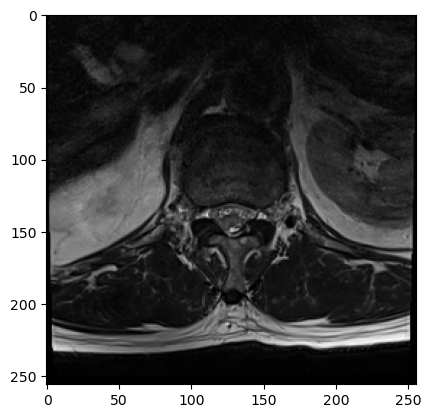

In [64]:
plt.imshow(img[0], cmap='gray')

### Datamodule

In [65]:
from dataset import rsna_inf_dataset

In [66]:
class inference_datamodule(pl.LightningDataModule):
    def __init__(self, files_df, coords_df, cfg=CFG, tfs=None):
        super().__init__()
        
        self.files_df = files_df
        self.coords_df = coords_df
        
        self.bs = cfg.BATCH_SIZE
        self.tfs = tfs
        self.cfg = cfg
        
        self.num_workers = cfg.num_workers
        
    def predict_dataloader(self):
        ds = rsna_inf_dataset(self.files_df, self.coords_df, self.cfg, tfs=self.tfs, mode='train')
        
        train_loader = torch.utils.data.DataLoader(
            ds,
            batch_size=self.bs,
            pin_memory=False,
            drop_last=False,
            # shuffle=True,
            persistent_workers=True,
            num_workers=self.num_workers,
        )
        
        return train_loader

In [67]:
t_df = selection[:-100]


CFG2 = CFG()
# CFG2 = copy.deepcopy(CFG)
CFG2.BATCH_SIZE = 16
CFG2.num_workers = 2

dm = inference_datamodule(files_df, t_df, cfg=CFG2)

x, ids, y = next(iter(dm.predict_dataloader()))
x.shape, len(y), x.dtype,

(torch.Size([16, 3, 256, 256]), 16, torch.float32)

In [68]:
y[0]

tensor([0., 0., 0., 0., 0., 1.])

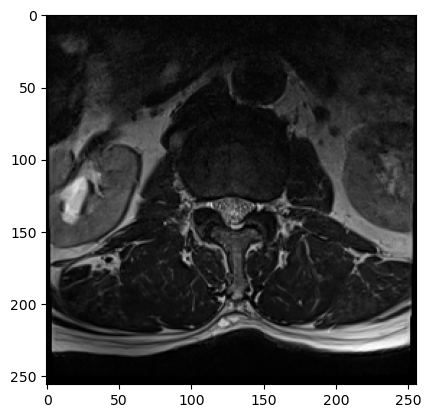

In [69]:
plt.imshow(x[10][0], cmap='gray')

#### Check Transforms

In [70]:
image_size = CFG.image_size

img_mean = (0.485, 0.456, 0.406)
img_std = (0.229, 0.224, 0.225)

train_tfs = A.Compose([
    # A.HorizontalFlip(p=0.5),
    A.Resize(image_size, image_size),
    A.CoarseDropout(max_height=int(image_size * 0.2), max_width=int(image_size * 0.2), max_holes=4, p=0.7),
    A.Normalize(mean=img_mean, std=img_std)
])

val_tfs = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=img_mean, std=img_std)
])

In [71]:
dm = inference_datamodule(files_df, t_df, cfg=CFG2, tfs=val_tfs)
# dm = wav_datamodule(t_df, v_df, cfg=CFG, train_tfs=train_tfs, val_tfs=val_tfs)

x, ids, y = next(iter(dm.predict_dataloader()))
x.shape, x.dtype,

(torch.Size([16, 3, 256, 256]), torch.float32)

In [72]:
y[0], ids[0]

(tensor([0., 0., 0., 0., 0., 1.]), '100206310_1012284084_1')

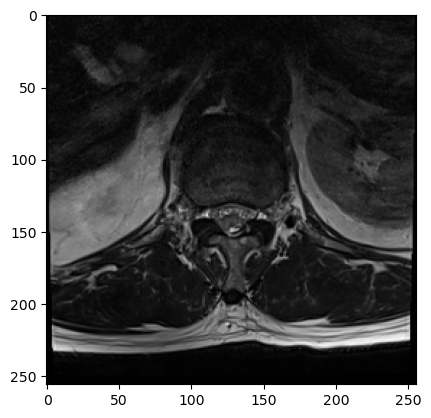

In [73]:
plt.imshow(x[2][0], cmap='gray')

In [74]:
del dm

### Loss function

In [75]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss

In [76]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x

### Model

In [77]:
backbone = 'eca_nfnet_l1'
# backbone = 'efficientnet_b4'
out_indices = (3, 4)

model = timm.create_model(
    backbone,
    features_only=True,
    pretrained=False,
    in_chans=3,
    num_classes=dset.num_classes,
    # out_indices=out_indices,
    )

model.feature_info.channels(), np.sum(model.feature_info.channels())

([64, 256, 512, 1536, 3072], 5440)

In [78]:
data_config = timm.data.resolve_model_data_config(model)

In [79]:
data_config

{'input_size': (3, 256, 256),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [80]:
def mixup(data, targets, alpha, device):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)]).to(device)
    data = data * lam + data2 * (1 - lam)
    
    targets = targets * lam + targets2 * (1 - lam)
    return data, targets

    # data += data2
    # targets += targets2
    # return data, targets.clip(max=1)

In [81]:
class GeMModel(pl.LightningModule):
    def __init__(self, cfg = CFG, pretrained = True):
        super().__init__()

        self.cfg = cfg

        self.dev = cfg.device
        
        out_indices = (3, 4)

        self.bottleneck_dim = cfg.bottleneck_dim

        self.criterion = FocalLossBCE()

        wrapped_acc = ClasswiseWrapper(MultilabelAccuracy(num_labels=self.cfg.N_LABELS, average='none'), labels=classes, prefix='multiacc/')
        wrapped_f1 = ClasswiseWrapper(MultilabelF1Score(num_labels=self.cfg.N_LABELS, average='none'), labels=classes, prefix='multif1/')
        
        metrics = MetricCollection({
            # 'macc': MultilabelAccuracy(num_labels=self.cfg.N_LABELS),
            'none_acc': wrapped_acc,
            'mpr': MultilabelPrecision(num_labels=self.cfg.N_LABELS),
            'mrec': MultilabelRecall(num_labels=self.cfg.N_LABELS),
            'f1': MultilabelF1Score(num_labels=self.cfg.N_LABELS),
            'none_f1': wrapped_f1,
        })

        self.train_metrics = metrics.clone(prefix='train/')
        self.valid_metrics = metrics.clone(prefix='val/')
        
        # self.model_name = self.cfg.model_name
        print(self.cfg.model_name)
        
        self.backbone = timm.create_model(
            self.cfg.model_name, 
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=self.cfg.N_LABELS,
            out_indices=out_indices,
        )

        feature_dims = self.backbone.feature_info.channels()

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.bottleneck = torch.nn.Linear(self.mid_features, self.bottleneck_dim)
        self.bottleneck_bn = torch.nn.BatchNorm1d(self.bottleneck_dim)
        self.head = torch.nn.Linear(self.bottleneck_dim, self.cfg.N_LABELS)

    def pre_forward(self, x):
        ms = self.backbone(x)
        
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.bottleneck(x)
        x = self.bottleneck_bn(x)

        return x
    
    def forward(self, x):
        x = self.pre_forward(x)

        x = self.head(x)
        
        return x
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.cfg.LEARNING_RATE, weight_decay=CFG.weight_decay)
        
        if self.cfg.USE_SCHD:
            scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.cfg.COS_EPOCHS)
            scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=self.cfg.WARM_EPOCHS, after_scheduler=scheduler_cosine)

            return [optimizer], [scheduler_warmup]
        else:
            # LRscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
            
            # return [optimizer], [LRscheduler]
            return optimizer

    def step(self, batch, batch_idx, mode='train'):
        x, y = batch

        if self.cfg.MIXUP and mode == 'train':
            x, y = mixup(x, y, 0.5, self.cfg.device)
        
        preds = self(x)
        
        loss = self.criterion(preds, y)
        
        if mode == 'train':
            output = self.train_metrics(preds, y)
            self.log_dict(output)
        else:
            self.valid_metrics.update(preds, y)

        self.log(f'{mode}/loss', loss, on_step=True, on_epoch=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='train')
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='val')
    
        return loss
    
    def on_train_epoch_end(self):
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        output = self.valid_metrics.compute()
        self.log_dict(output)

        self.valid_metrics.reset()

In [82]:
class featureModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()

        self.model = model

    def forward(self, x):
        embeds = self.model.pre_forward(x)
        preds = self.model.head(embeds)
        
        return preds, embeds

    def predict_step(self, batch):
        imgs, ids, targets = batch

        preds, embeds = self(imgs)

        t_df = pd.DataFrame(targets.detach().cpu().numpy(), columns=CFG.classes)
        p_df = pd.DataFrame(preds.sigmoid().detach().cpu().numpy(), columns=pred_labels)

        results_df = pd.DataFrame(ids, columns = ['ids'])
        results_df = pd.concat([results_df, t_df, p_df], axis=1)
    
        return embeds.detach().cpu().numpy(), results_df, ids

In [83]:
model = GeMModel(CFG)
fmodel = featureModel(model)

eca_nfnet_l0


In [84]:
preds, results, ids = fmodel.predict_step((x, ids, y))

In [85]:
preds.shape

(16, 128)

In [86]:
ids[:4]

('100206310_1012284084_1',
 '100206310_1012284084_10',
 '100206310_1012284084_11',
 '100206310_1012284084_12')

In [87]:
preds[0]

array([-2.31773943e-01, -1.04678142e+00, -1.02907503e+00,  1.93908107e+00,
        1.00857770e+00,  1.40648693e-01, -1.54589385e-01, -1.30375922e+00,
        1.13950658e+00, -9.06093642e-02,  6.45168364e-01, -3.64980966e-01,
       -1.19327940e-03,  8.65020514e-01,  1.77025467e-01,  1.62927294e+00,
       -1.25148678e+00, -2.95351595e-01,  3.32321495e-01,  7.44042754e-01,
       -2.02227688e+00, -5.86529315e-01,  1.67473340e+00,  4.79732066e-01,
        9.29980814e-01,  1.30873871e+00, -1.84297979e-01,  1.51756370e+00,
        1.89158010e+00, -4.66319323e-01,  1.72760284e+00, -1.48422313e+00,
       -1.38893437e+00, -7.76484847e-01,  5.26552677e-01,  8.58612418e-01,
        1.76986575e+00, -2.18969321e+00, -5.53871036e-01, -1.18078935e+00,
        3.66953045e-01,  7.78917730e-01, -1.87974676e-01, -1.35191214e+00,
        5.77736557e-01, -6.82814419e-01,  4.42165881e-01,  7.57023036e-01,
        1.02082384e+00, -8.37562323e-01, -1.09171629e+00, -8.69538665e-01,
       -4.57788944e-01, -

In [88]:
results.shape

(16, 13)

In [90]:
results

,ids,SCS,RNFN,LNFN,LSS,RSS,H,pred_SCS,pred_RNFN,pred_LNFN,pred_LSS,pred_RSS,pred_H
0,100206310_1012284084_1,0.0,0.0,0.0,0.0,0.0,1.0,0.605169,0.715982,0.435817,0.455911,0.698104,0.600019
1,100206310_1012284084_10,0.0,0.0,0.0,0.0,0.0,1.0,0.684745,0.590653,0.569526,0.577220,0.797408,0.591806
2,100206310_1012284084_11,0.0,0.0,0.0,0.0,0.0,1.0,0.672131,0.427044,0.375590,0.771495,0.359636,0.460826
3,100206310_1012284084_12,0.0,0.0,0.0,0.0,0.0,1.0,0.569009,0.513605,0.401506,0.397181,0.530792,0.717655
4,100206310_1012284084_13,0.0,0.0,0.0,0.0,0.0,1.0,0.395068,0.466160,0.504576,0.263194,0.437199,0.650792
5,100206310_1012284084_14,0.0,0.0,0.0,0.0,0.0,1.0,0.478491,0.332368,0.494978,0.376563,0.543645,0.687123
6,100206310_1012284084_15,0.0,0.0,0.0,0.0,0.0,1.0,0.580303,0.506099,0.342341,0.568004,0.617194,0.462328
7,100206310_1012284084_16,0.0,0.0,0.0,0.0,0.0,1.0,0.692623,0.318270,0.524403,0.657136,0.242352,0.681224
8,100206310_1012284084_17,0.0,0.0,0.0,0.0,0.0,1.0,0.519823,0.678570,0.403869,0.570840,0.294893,0.702566
9,100206310_1012284084_18,0.0,0.0,0.0,0.0,0.0,1.0,0.733549,0.496929,0.520247,0.735525,0.444313,0.348459


### Inference

In [91]:
CFG.ckpt_path

WindowsPath('E:/data/RSNA2024/results/ckpt/eca_nfnet_l0 5e-05 10 eps 128neck/ep_04_loss_0.17137.ckpt')

In [92]:
model = GeMModel.load_from_checkpoint(checkpoint_path=CFG.ckpt_path, cfg=CFG)
model = featureModel(model)

accelerator = CFG.device

trainer = pl.Trainer(
    accelerator=accelerator,
)

print('model loaded')

eca_nfnet_l0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\ProgramData\anaconda3\envs\rsna\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


model loaded


In [93]:
model.to(accelerator)
model.eval()
model.freeze()

accelerator

'cuda'

In [94]:
files_df.shape, files_df.filename.nunique(), coords_df.filename.nunique()

((147218, 20), 147218, 24546)

In [106]:
train_cols = ['filename', 'healthy', 'series_description', 'instance_id']

In [107]:
files_df.loc[:, train_cols].head(2)

,filename,healthy,series_description,instance_id
0,E:\data\RSNA2024\pngs_256\100206310_1012284084...,True,Axial T2,100206310_1012284084_1
1,E:\data\RSNA2024\pngs_256\100206310_1012284084...,True,Axial T2,100206310_1012284084_10


In [109]:
# files_df.condition.unique()

#### Predict

In [110]:
CFG.BATCH_SIZE, CFG.device

(128, 'cuda')

In [112]:
# make sure files_df has the correct condition
# dm = inference_datamodule(healthy_df[:248], tfs=val_tfs)
dm = inference_datamodule(files_df, coords_df, tfs=val_tfs)
# dm = inference_datamodule(coords_df, tfs=val_tfs)

In [113]:
trainer = pl.Trainer(accelerator=CFG.device)
predictions = trainer.predict(model, dataloaders=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                             | 0/? [00:00<?, ?it/…

In [114]:
len(predictions)

1151

In [115]:
predictions[0][0].shape, predictions[0][1].shape, len(predictions[0][2])

((128, 128), (128, 13), 128)

In [116]:
predictions[0][2][:4]

('100206310_1012284084_1',
 '100206310_1012284084_10',
 '100206310_1012284084_11',
 '100206310_1012284084_12')

In [117]:
predictions[0][1].head(2)

,ids,SCS,RNFN,LNFN,LSS,RSS,H,pred_SCS,pred_RNFN,pred_LNFN,pred_LSS,pred_RSS,pred_H
0,100206310_1012284084_1,0.0,0.0,0.0,0.0,0.0,1.0,0.008687,0.005704,0.003396,0.008272,0.010076,0.996422
1,100206310_1012284084_10,0.0,0.0,0.0,0.0,0.0,1.0,0.009786,0.005203,0.004467,0.010467,0.013595,0.994842


In [118]:
(preds, results, ids) = list(map(list, zip(*predictions)))

### Save predictions

#### Save results

In [119]:
results = pd.concat(results, ignore_index=True)
results.shape

(147218, 13)

In [142]:
results.head()

,ids,SCS,RNFN,LNFN,LSS,RSS,H,pred_SCS,pred_RNFN,pred_LNFN,pred_LSS,pred_RSS,pred_H,study_id,series_id,instance
0,100206310_1012284084_1,0.0,0.0,0.0,0.0,0.0,1.0,0.008687,0.005704,0.003396,0.008272,0.010076,0.996422,100206310,1012284084,1
1,100206310_1012284084_10,0.0,0.0,0.0,0.0,0.0,1.0,0.009786,0.005203,0.004467,0.010467,0.013595,0.994842,100206310,1012284084,10
2,100206310_1012284084_11,0.0,0.0,0.0,0.0,0.0,1.0,0.010766,0.004137,0.004125,0.011050,0.014827,0.987138,100206310,1012284084,11
3,100206310_1012284084_12,0.0,0.0,0.0,0.0,0.0,1.0,0.010275,0.004786,0.005259,0.018689,0.022448,0.970648,100206310,1012284084,12
4,100206310_1012284084_13,0.0,0.0,0.0,0.0,0.0,1.0,0.009548,0.003647,0.004661,0.014746,0.016192,0.981966,100206310,1012284084,13


In [141]:
results.head().index.tolist()

[0, 1, 2, 3, 4]

In [120]:
results.sample(2)

,ids,SCS,RNFN,LNFN,LSS,RSS,H,pred_SCS,pred_RNFN,pred_LNFN,pred_LSS,pred_RSS,pred_H
29003,1777680877_2447990181_32,0.0,0.0,0.0,0.0,0.0,1.0,0.010301,0.004611,0.003562,0.012105,0.017671,0.994959
91636,3397114375_2204354751_9,0.0,0.0,0.0,0.0,0.0,1.0,0.016625,0.010799,0.005918,0.014675,0.013823,0.981366


In [121]:
results['study_id'] = results['ids'].apply(lambda x: x.split('_')[0])
results['series_id'] = results['ids'].apply(lambda x: (x.split('_')[1]))
results['instance'] = results['ids'].apply(lambda x: int(x.split('_')[-1]))

In [122]:
results.head(2)

,ids,SCS,RNFN,LNFN,LSS,RSS,H,pred_SCS,pred_RNFN,pred_LNFN,pred_LSS,pred_RSS,pred_H,study_id,series_id,instance
0,100206310_1012284084_1,0.0,0.0,0.0,0.0,0.0,1.0,0.008687,0.005704,0.003396,0.008272,0.010076,0.996422,100206310,1012284084,1
1,100206310_1012284084_10,0.0,0.0,0.0,0.0,0.0,1.0,0.009786,0.005203,0.004467,0.010467,0.013595,0.994842,100206310,1012284084,10


In [123]:
results.study_id.nunique()

1975

In [125]:
#  dont sort
# table and embeding order must match

In [126]:
# results = results.sort_values(by=['study_id', 'series_id', 'instance'], ascending=[True, True, True], ignore_index=True)

# results.shape

In [127]:
results.study_id.nunique()

1975

In [128]:
# results.head(5)

In [129]:
results.index[results['study_id'] == '1002894806']

Index([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173],
      dtype='int64')

In [130]:
results[results['study_id'] == '1002894806'].head()

,ids,SCS,RNFN,LNFN,LSS,RSS,H,pred_SCS,pred_RNFN,pred_LNFN,pred_LSS,pred_RSS,pred_H,study_id,series_id,instance
96,1002894806_1252873726_1,0.0,0.0,0.0,0.0,0.0,1.0,0.012720,0.005766,0.004333,0.018424,0.018601,0.980531,1002894806,1252873726,1
97,1002894806_1252873726_10,0.0,0.0,0.0,0.0,0.0,1.0,0.011499,0.007655,0.008143,0.033114,0.041246,0.948285,1002894806,1252873726,10
98,1002894806_1252873726_11,0.0,0.0,0.0,0.0,0.0,1.0,0.012720,0.006360,0.007804,0.083649,0.065060,0.825550,1002894806,1252873726,11
99,1002894806_1252873726_12,0.0,0.0,0.0,1.0,0.0,0.0,0.012415,0.006567,0.006452,0.465788,0.431943,0.185608,1002894806,1252873726,12
100,1002894806_1252873726_13,0.0,0.0,0.0,0.0,1.0,0.0,0.011063,0.006081,0.005381,0.351137,0.386445,0.192536,1002894806,1252873726,13


In [131]:
results[results.pred_H > 0.8].shape, results[results.pred_H < 0.8].shape

((103248, 16), (43970, 16))

In [135]:
results[results.H < 1].shape

(24546, 16)

In [136]:
results[results.H < 1].sample(2)

,ids,SCS,RNFN,LNFN,LSS,RSS,H,pred_SCS,pred_RNFN,pred_LNFN,pred_LSS,pred_RSS,pred_H,study_id,series_id,instance
58432,2550694704_937840626_8,0.0,0.0,0.0,0.0,1.0,0.0,0.008676,0.005967,0.003719,0.544802,0.615703,0.049328,2550694704,937840626,8
28733,1768692511_1766321945_12,0.0,0.0,1.0,0.0,0.0,0.0,0.009556,0.011857,0.999795,0.015912,0.016972,0.005601,1768692511,1766321945,12


In [132]:
results.to_csv(CFG.DEST_FOLDER / 'predictions.csv', index=False)

#### Save embeddings

In [133]:
stacked = np.vstack(preds)
stacked.shape

(147218, 128)

In [134]:
np.save(CFG.stacked_path / f'stacked.npy', stacked)

In [90]:
# for (embeds, ids) in zip(preds, ids):
#     for emb, file in zip(embeds, ids):
#         np.save(CFG.embeds_path / f'{file}.npy', emb)

In [91]:
# for x, y in results.groupby(['study_id', 'series_id']):   
#     filename = CFG.stacked_path / f'{x[0]}_{x[1]}.npy'

#     files = [CFG.embeds_path / f'{file}.npy' for file in y.ids.tolist()]

#     files = [np.load(f) for f in files]

#     stacked = np.vstack(files)

#     np.save(filename, stacked)